In [1]:
import geopandas
import matplotlib.pyplot as plt

In [2]:
df=geopandas.read_file("ne_110m_admin_0_countries.shp")
#df=geopandas.read_file("MAROC.shp")



In [3]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

# For attribute join
country_shapes = world[['geometry', 'iso_a3']]

country_names = world[['name', 'iso_a3']]

# For spatial join
countries = world[['geometry', 'name']]

countries = countries.rename(columns={'name':'country'})

countries.head()

,geometry,country
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",W. Sahara
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America


C:\Users\GUERBOUB MHAMED\AppData\Local\Temp\ipykernel_32828\1118222812.py:29: DeprecationWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  stamen_terrain              = cimgt.StamenTerrain()
C:\Users\GUERBOUB MHAMED\anaconda3\envs\envir\lib\site-packages\cartopy\feature\__init__.py:217: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  self._geoms = tuple(geometries)
C:\Users\GUERBOUB MHAMED\anaconda3\envs\envir\lib\site-packages\cartopy\feature\__init__.py:217: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  self._geoms = tuple(geometries)


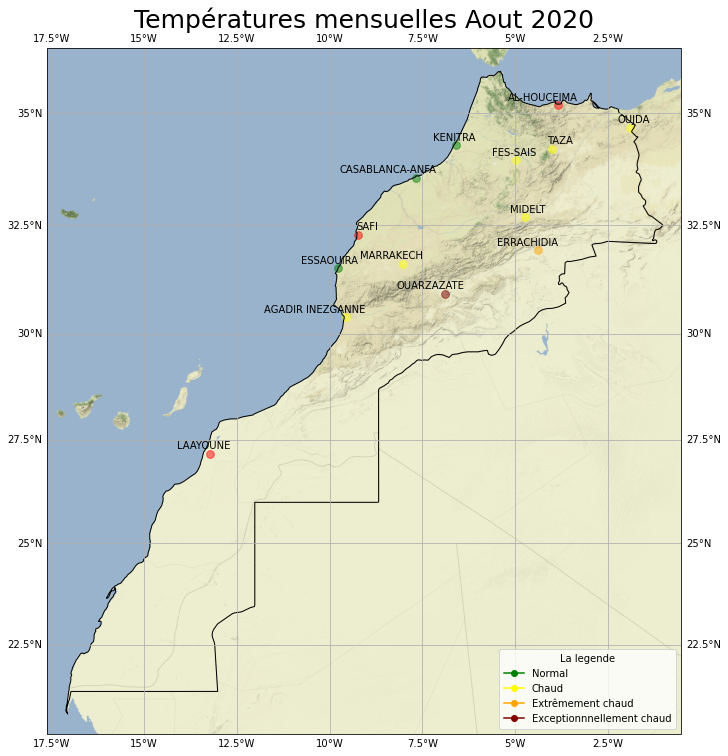

In [123]:
from shapely.geometry import Polygon
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
import matplotlib.pyplot as plt


def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""    
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]

# request data for use by geopandas
resolution          = '10m'
category            = 'cultural'
name                = 'admin_0_countries'
countries           = ['Western Sahara','Morocco']
shpfilename         = shapereader.natural_earth(resolution, category, name)
df                  = geopandas.read_file(shpfilename)
extent              = [-20, 0, 20, 38]

# get geometry of a country

scan3 = df[ df['ADMIN'].isin(['Western Sahara','Morocco']) ]
scan3_dissolved = scan3.dissolve(by='LEVEL')
poly = [scan3_dissolved['geometry'].values[0]]
stamen_terrain              = cimgt.StamenTerrain()

# projections that involved
st_proj = stamen_terrain.crs  #projection used by Stamen images
ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat
colors={'Exceptionnnellement chaud':'maroon','Extrêmement chaud':'orange','Très chaud':'red','Chaud':'yellow',
         'Normal':'green','Froid':'azure','Très froid':'aqua','Exceptionnellement froid':'blue','Extrêmement froid':'indige'}
df4 = pd.read_csv('fil.csv', encoding = "ISO-8859-1", engine='python')



fig = plt.figure(figsize=(25,22))
ax = fig.add_subplot(122, projection=st_proj)
ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')
pad1 = 0.5 
exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
ax.set_extent(exts, crs=ll_proj)
# make a mask polygon by polygon's difference operation
msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
msk_stm  = st_proj.project_geometry (msk, ll_proj)  # project geometry to the projection used by stamen
# get and plot Stamen images
ax.add_image(stamen_terrain, 8) 
# plot the mask using semi-transparency (alpha=0.65) on the masked-out portion
ax.add_geometries( msk_stm, st_proj, zorder=12, facecolor='white', edgecolor='none', alpha=0)
ax.gridlines(draw_labels=True)
for i,row in df4.iterrows():
    ax.scatter(x=row['Longitude'], y=row['Latitude'], label=row['ClassTemp'], c=colors[row['ClassTemp']], s=60, alpha=0.5, transform=ccrs.PlateCarree())

ax.set_title('Températures mensuelles Aout 2020', fontdict={'fontsize': '25', 'fontweight' : '3'})

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=20, y=8)
for i in range(len(df4)):
    ax.text(x=df4.Longitude[i], y=df4.Latitude[i], s=df4.StName[i],
            verticalalignment='center', horizontalalignment='right', 
            transform=text_transform)

    
#### Construction de la légende
dfclass=pd.DataFrame(df4['ClassTemp'].unique(), columns=['class'])
color=[]
for a in df4['ClassTemp'].unique():
    color.append(colors[a])
dfclass['color']=color

#legend_elements=[]
str1=''
for i,row in dfclass.iterrows():
    str="Line2D([0],[0],marker='o',color='" + row['color'] + "', label=" + "'"+ row['class']
    #legend_elements.append(str) probleeeeeeeeeeeeeeeme
legend_elements = [Line2D([0],[0],marker='o',color='green', label='Normal'),
                  Line2D([0],[0],marker='o',color='yellow', label='Chaud'),
                  Line2D([0],[0],marker='o',color='orange', label='Extrêmement chaud'),
                  Line2D([0],[0],marker='o',color='maroon', label='Exceptionnnellement chaud')]


ax.legend(handles=legend_elements, loc="lower right", ncol =1 , 
         scatterpoints = 1, frameon = True, markerscale = 1, title = 'La legende',
          borderpad = 0.5, labelspacing = 0.5)
plt.savefig('carteTemp2.pdf')
plt.show()



In [17]:
import pandas as pd
df4 = pd.read_csv('fil.csv', encoding = "ISO-8859-1", engine='python')

colors={'Exceptionnnellement chaud':'maroon','Extrêmement chaud':'orange','Très chaud':'red','Chaud':'yellow',
         'Normal':'beige','Froid':'azure','Très froid':'aqua','Exceptionnellement froid':'blue','Extrêmement froid':'indige'}
dfclass=pd.DataFrame(df4['ClassTemp'].unique(), columns=['class'])
color=[]
for a in df4['ClassTemp'].unique():
    color.append(colors[a])
dfclass['color']=color
dfclass



,class,color
0,Très chaud,red
1,Chaud,yellow
2,Normal,beige
3,Extrêmement chaud,orange
4,Exceptionnnellement chaud,maroon


In [3]:
import cartopy.crs as ccrs  
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas
from matplotlib.transforms import offset_copy
import numpy as np
from cartopy.io import shapereader
import pandas as pd
import re
from matplotlib.patches.Circle import Circle

resolution          = '10m'
category            = 'cultural'
name                = 'admin_0_countries'
countries           = ['Western Sahara','Morocco']
shpfilename         = shapereader.natural_earth(resolution, category, name)
df                  = geopandas.read_file(shpfilename)
ll_proj             = ccrs.PlateCarree()

colors={'Exceptionnnellement chaud':'maroon','Extrêmement chaud':'orange','Très chaud':'red','Chaud':'yellow',
         'Normal':'green','Froid':'azure','Très froid':'aqua','Exceptionnellement froid':'blue','Extrêmement froid':'indige'}
df4 = pd.read_csv('fil.csv', encoding = "ISO-8859-1", engine='python')

scan3 = df[ df['ADMIN'].isin(['Western Sahara','Morocco']) ]
scan3_dissolved = scan3.dissolve(by='LEVEL')
poly = [scan3_dissolved['geometry'].values[0]]


fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-20, 0, 20, 38], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.5) 
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)

for i,row in df4.iterrows():
    ax.scatter(x=row['Longitude'], y=row['Latitude'], label=row['ClassTemp'], c=colors[row['ClassTemp']], s=60, alpha=0.5, transform=ccrs.PlateCarree())

ax.set_title('Températures mensuelles Aout 2020', fontdict={'fontsize': '25', 'fontweight' : '3'})

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=20, y=8)
for i in range(len(df4)):
    ax.text(x=df4.Longitude[i], y=df4.Latitude[i], s=df4.StName[i],
            verticalalignment='center', horizontalalignment='right', 
            transform=text_transform)

    
#### Construction de la légende
dfclass=pd.DataFrame(df4['ClassTemp'].unique(), columns=['class'])
color=[]
for a in df4['ClassTemp'].unique():
    color.append(colors[a])
dfclass['color']=color

#legend_elements=[]
str1=''
for i,row in dfclass.iterrows():
    str="Line2D([0],[0],marker='o',color='" + row['color'] + "', label=" + "'"+ row['class']
    #legend_elements.append(str) probleeeeeeeeeeeeeeeme
"""
legend_elements = [Line2D([0],[0],marker='o',color='green', label='Normal'),
                  Line2D([0],[0],marker='o',color='yellow', label='Chaud'),
                  Line2D([0],[0],marker='o',color='orange', label='Extrêmement chaud'),
                  Line2D([0],[0],marker='o',color='maroon', label='Exceptionnnellement chaud')]
"""
legend_elements = [(marker='o',label='Normal'),
                  (marker='o', label='Chaud'),
                  (marker='o', label='Extrêmement chaud'),
                  (marker='o', label='Exceptionnnellement chaud')]


ax.legend(handles=legend_elements, loc="lower right", ncol =1 , 
         scatterpoints = 1, frameon = True, markerscale = 1, title = 'La legende',
          borderpad = 0.5, labelspacing = 0.5)
plt.savefig('carteTemp.png')
plt.show()


SyntaxError: invalid syntax (2473620867.py, line 73)

In [54]:
import pandas as pd
dfstat = pd.read_csv("CLINO_Morocco_Metadata.csv", delimiter=";")
dfindic = pd.read_csv("AnomaliStandAug2020.csv", delimiter=",")
dfindic.drop(columns='Unnamed: 0',inplace=True)
print(dfstat.columns)
print(dfindic.columns)


Index(['StCode', 'WMOid', 'WIGOSid', 'Latitude', 'Longitude', 'Elevation',
       'StName', 'Country'],
      dtype='object')
Index(['Station', 'MeanMensAbs', 'MeanMens2020', 'AnomalStand', 'ClassTemp'], dtype='object')


In [36]:
"""
cod=[]
for i in dfstat['StCode']:
    txt=str(i)+str('001')
    cod.append(txt)
dfstat['Station']=cod
"""
Name=[]
Lat=[]
Long=[]

for cod in dfindic['Station']:
    Name.append(dfstat[dfstat['StCode']==cod]['StName'])
    Lat.append(dfstat[dfstat['StCode']==cod]['Latitude'])
    Long.append(dfstat[dfstat['StCode']==cod]['Longitude'])

#dfindic['Name']=Name
#dfindic['Latitude']=Lat
#dfindic['Longitude']=Long

df3=dfstat[dfstat['StCode'].isin(dfindic['Station'])]
df3=df3[['StCode','StName','Latitude','Longitude']]
df3.to_csv('Coord.csv')
